# Brief descriptions: 

Calculating a 5 yr swap contract with fixed rate of 2.5%, and floating rate of USD Libor 6m, plot Expected Exposures, do sensitivity study with different fixed rate in range [0.01, 0.15], and with different floating rate of USD Libor 12m.

In [177]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import QuantLib as ql
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
from edward.models import Normal, MultivariateNormalTriL
plt.style.use('ggplot')
from edward.util import rbf
import pandas as pd
%matplotlib inline
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

# Definitions for swap calculation¶

In [4]:
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
        end = ql.TARGET().advance(start, maturity)
        fixedLegTenor = ql.Period("1y")
        fixedLegBDC = ql.ModifiedFollowing
        fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
        spread = 0.0
        fixedSchedule = ql.Schedule(start, end,  fixedLegTenor,   index.fixingCalendar(),   fixedLegBDC,  fixedLegBDC,   ql.DateGeneration.Backward,   False)
        floatSchedule = ql.Schedule(start, end,  index.tenor(),  index.fixingCalendar(),   index.businessDayConvention(),  index.businessDayConvention(),   ql.DateGeneration.Backward,  False)
        swap = ql.VanillaSwap(typ,  nominal,  fixedSchedule,  fixedRate,  fixedLegDC,  floatSchedule,  index,  spread,  index.dayCounter())
        return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

def makeSwaption(swap, callDates, settlement):
    if len(callDates) == 1:
        exercise = ql.EuropeanExercise(callDates[0])
    else:
        exercise = ql.BermudanExercise(callDates)
    return ql.Swaption(swap, exercise, settlement)

def timeFromReferenceFactory(daycounter, ref):
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

def getFixedLeg(swap, t):
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    npv = 0
    for i in range(n):
        cf = fixed_leg[i]
        t_i = timeFromReference(cf.date())
        if t_i > t:
            fixed_times.append(t_i)
            fixed_amounts.append(cf.amount())
    return np.array(fixed_times), np.array(fixed_amounts)

def getFloatingLeg(swap, t):
    float_leg = swap.leg(1)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        # convert base classiborstart_idx Cashflow to
        # FloatingRateCoupon
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf.append(cf.accrualPeriod())
            # calculate the start and end time
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            # payment time
            float_times.append(t_i)
            # nominals 
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)
    
def getFixedFloatingPeriod(swap, t):
    float_leg = swap.leg(1)
    n = len(float_leg)
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i < t and t < t_i:
            iborIndex = cf.index()         
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf = cf.accrualPeriod()
            # calculate the start and end time
            accrual_start_time = t_fix_i
            accrual_end_time = timeFromReference(index_mat)
            # payment time
            float_times = t_i
            # nominals 
            nominals = cf.nominal()
            return (float(float_times), float(float_dcf), float(accrual_start_time), float(accrual_end_time), float(nominals))
    return (float(t), 1., float(t), float(t), 0.)

def swapPathNPV(swap, t, timegrid):
    fixed_times, fixed_amounts = getFixedLeg(swap, t)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getFloatingLeg(swap, t)
    df_times = np.concatenate([fixed_times,  accrual_start_time, accrual_end_time, float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in 
    # the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times 
    # in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time
    # in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    paytime_ffp, float_dcf_ffp, accrual_start_time_ffp, accrual_end_time_ffp, nominals_ffp = getFixedFloatingPeriod(swap, t)
    # Calculate NPV
    def calc(path):
        if len(df_times)==0:
            return 0
        i = np.where(timegrid == t)[0][0]
        x_t = path[i]
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        # Calculate the already fixed accrual period of the floating leg
        t_f = accrual_start_time_ffp
        i = np.where(timegrid == t_f)[0][0]
        x_f = path[i]
        df_e = model.zerobond(accrual_end_time_ffp, t_f, x_f)
        npv_accrualperiod = (1. / df_e - 1) * nominals_ffp * model.zerobond(paytime_ffp, t, x_t)
        # Calculate swap npv
        npv = float_leg_npv + npv_accrualperiod - fix_leg_npv
        return npv
    return calc
    
def fixingdates(swap):
    leg = swap.leg(1)
    n = len(leg)
    fixing_dates = []
    for i in range(0, n):
        cf = ql.as_floating_rate_coupon(leg[i])
        value_date = cf.referencePeriodStart()
        fixing_dates.append(value_date)
    return fixing_dates 

today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)
fixedRate = 0.025
settlementDate = today + ql.Period("2D")


# Create a swap and plot EE

In [149]:
    rate = ql.SimpleQuote(0.03)   
    rate_handle = ql.QuoteHandle(rate)
    dc = ql.Actual365Fixed()
    yts = ql.FlatForward(today, rate_handle, dc)
    yts.enableExtrapolation()
    hyts = ql.RelinkableYieldTermStructureHandle(yts)
    t0_curve = ql.YieldTermStructureHandle(yts)
    libor1yr = ql.USDLibor(ql.Period(6, ql.Months), hyts)  
    cal = ql.TARGET()
    
    swaps = [makeSwap(settlementDate,  ql.Period("5Y"), 1e6,  fixedRate,  libor1yr) ]
    calldates = [ql.Date(7,4,2016), ql.Date(6,4,2017), ql.Date(5,4, 2018), ql.Date(5,4,2019)]
    #swaptions = [makeSwaption(swap,  calldates,  ql.Settlement.Physical)  for swap, fd in swaps]
    calldates = [libor1yr.valueDate(d) for d in calldates]
    
    # Assume the model is already calibrated either historical or market implied
    volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)), ql.QuoteHandle(ql.SimpleQuote(0.0075))]
    meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
    model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
    process = model.stateProcess()
    #swaptionEngine = ql.Gaussian1dSwaptionEngine(model)
    #for swaption in swaptions:
        #swaption.setPricingEngine(swaptionEngine)
    
    mcDC = yts.dayCounter()
    timeFromReference = timeFromReferenceFactory(mcDC, today)
    
    callTimes = timeFromReference(calldates)
    swap = swaps[0][0]    
    #swaption = swaptions[0]
    npv = swapPathNPV(swap, 0., np.array([0.]))(np.array([0.]))
    
    fixing_dates = fixingdates(swap)
    fixing_times = timeFromReference(fixing_dates )

    date_grid = [today + ql.Period(i, ql.Months) for i in range(0,66)] + calldates + fixing_dates

    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
    time_grid = np.unique(time_grid)
    dt = time_grid[1:] - time_grid[:-1]
    
    seed = 1
    urng = ql.MersenneTwisterUniformRng(seed)
    usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
    generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

    M = 10000
    m = len(time_grid)
    x = np.zeros((M, m))
    y = np.zeros((M, m))
    numeraires = np.zeros((M, m))
                      
    for n in range(0, M):
        numeraires[n, 0] = model.numeraire(0, 0)
    
    for n in range(0,M):
        dWs = generator.nextSequence().value()
        j = 1
        for i in range(1, len(time_grid)):
            t0 = time_grid[i-1]
            t1 = time_grid[i]
            e = process.expectation(t0, x[n,i-1],   dt[i-1])
            std = process.stdDeviation(t0,   x[n,i-1],  dt[i-1])
            x[n,i] = e + dWs[i-1] * std 
            e_0_0 = process.expectation(0,0,t1)
            std_0_0 = process.stdDeviation(0,0,t1)
            y[n,i] = (x[n,i] - e_0_0) / std_0_0
            numeraires[n, i] = model.numeraire(t1, y[n,i])
        
    swap_npvs = np.zeros((M, m))    
    #swaption_npvs = np.zeros((M, m))
    cont_value = np.zeros(numeraires[:,i].shape)
    for i in range(m-1, 0, -1):
        t = time_grid[i]
        pricer = swapPathNPV(swap, t, time_grid)
        swap_npvs[:, i] = np.apply_along_axis(pricer, 1, y) / numeraires[:, 0]     
        exercise_values = np.zeros(numeraires[:,i].shape)
        if t in callTimes:
            exercise_values = swap_npvs[:, i].copy()
            exercise_values[exercise_values < 0] = 0
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(cont_value, Y)
        ols_result = ols.fit()
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
        #swaption_npvs[:,i] = np.maximum(cont_value_hat, exercise_values)
        if t in callTimes:
            cont_value = np.maximum(cont_value_hat, exercise_values)
            #swaption_npvs[cont_value_hat < exercise_values, i:] = swap_npvs[cont_value_hat < exercise_values, i:].copy()
    #swaption_npvs[:,0] = np.mean(cont_value)
    swap_npvs[:, 0] = np.apply_along_axis(swapPathNPV(swap, 0, time_grid), 1, y) / numeraires[:, 0]      # delete after calculation
    
    #swaption_npvs *= numeraires[0,0]
    swap_npvs *= numeraires[0,0]     # delete after calculation
    
    swap_npvs[swap_npvs<0] = 0       # delete after calculation
    #swaption_npvs[swaption_npvs<0] = 0
    #EE_swaption = np.mean(swaption_npvs, axis=0)
    EE_swap = np.mean(swap_npvs, axis=0)     # delete after calculation

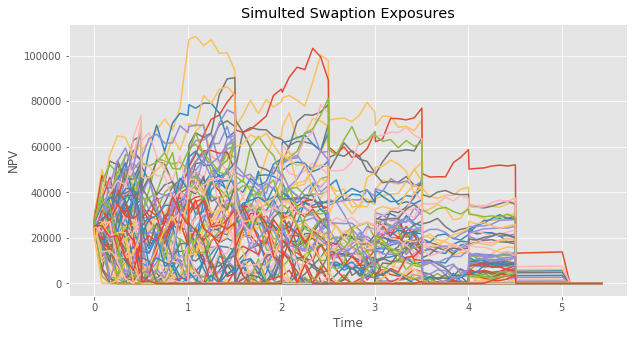

In [151]:
plt.figure(figsize=(10,5))
plt.grid(True)
for i in range(1, 100):
    plt.plot(time_grid, swap_npvs.T[:,i])
    plt.title("Simulted Swaption Exposures")
    plt.xlabel("Time")
    plt.ylabel("NPV")

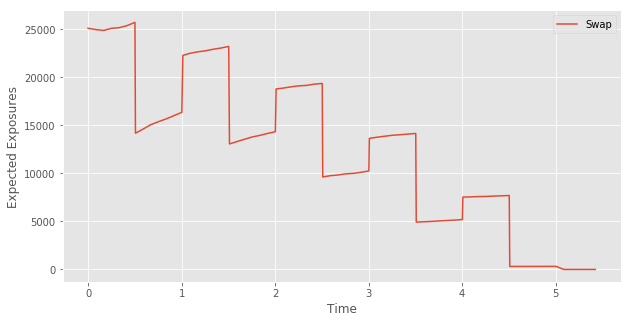

In [153]:
plt.figure(figsize=(10,5))
plt.plot(time_grid, EE_swap)
plt.xlabel("Time")
plt.ylabel("Expected Exposures")
plt.grid(True)
plt.legend(["Swap"])

# Sensitivity study and fitting GP with varying fixed rate

Given the range of fixed rate is from 0.01 to 0.15, which is too small for kernel function to reflect their relationship, we can multiply a scaler to change expand the change in fixed rate, as well as the noise term applied to K_noise. with different parameters below, we can obtain different training result.

In [126]:
# read in .csv file
df = pd.read_csv('/Users/jinxiwen/Desktop/RA/Cases/fix-CVA data.csv', header=None)
x = np.array(df.iloc[:,0])
y = np.array(df.iloc[:,1])

In [127]:
sess = ed.get_session()
training_number = 199     # change training size to see different training results.
testing_number = 10
scaler = 100
noise_term = 1e-1
l = 1.
sigma = 1.

train_idx = np.linspace(0, len(x)-1, training_number, dtype = 'int')
test_idx = np.linspace(0, len(x)-1, testing_number, dtype = 'int')

x_train = np.array(x[train_idx], dtype='float32').reshape(training_number, 1) * scaler
y_train = np.array(y[train_idx], dtype='float32').reshape(training_number, 1)
x_test = np.array(x[test_idx], dtype='float32').reshape(len(x[test_idx]), 1) * scaler
y_test = np.array(y[test_idx], dtype='float32').reshape(len(x[test_idx]), 1)

In [128]:
# mean
Kernel = rbf(x_train, lengthscale = l, variance = sigma).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  
k_s = rbf(x_test, x_train, lengthscale = l, variance = sigma).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(x_test).eval() - np.dot(v.T, v)

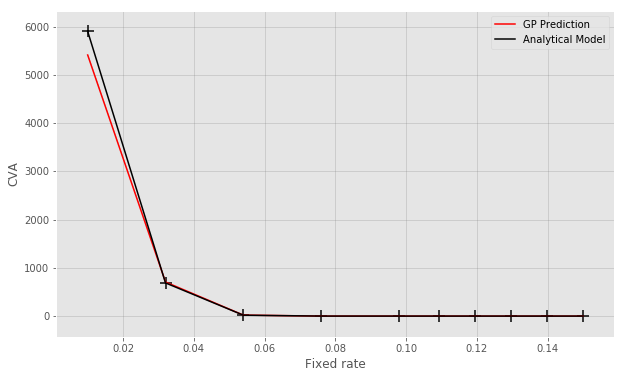

In [129]:
# plot with cov band
up = predict_mean.reshape(len(x[test_idx]),) - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean.reshape(len(x[test_idx]),) + 2 * (np.sqrt(np.diag(var)))

plt.figure(figsize = (10,6), facecolor='white', edgecolor='white')
plt.plot(x_test/scaler, predict_mean, color = 'red', label = 'GP Prediction')
plt.plot(x_test/scaler, y_test, color = 'black', label = 'Analytical Model')
plt.scatter(x_test/scaler,y_test, s = 150, color = 'black', marker = "+")
plt.fill_between(x[test_idx] , up, down, color = 'grey', alpha=0.3)
plt.grid(True, color = 'grey', alpha = 0.3)
plt.xlabel('Fixed rate')
plt.ylabel('CVA')
plt.legend(loc = 'best', prop={'size':10})

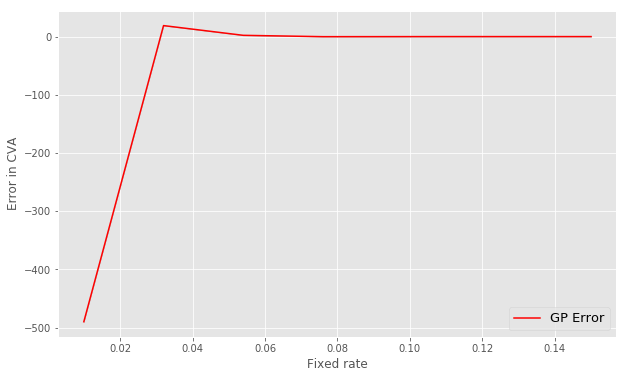

In [141]:
# Error plot
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test/scaler, predict_mean - y_test, color = 'red', label = 'GP Error')
#plt.plot(x_train, y_train, color = 'black', label = 'Analytical Model')
#plt.scatter(x_test, y_test, s = 150, color = 'black', marker = "+")
plt.fill_between((x_test/scaler).flatten(), up-y_test.flatten(), down - y_test.flatten(), color = 'grey', alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('Fixed rate')
plt.ylabel('Error in CVA')
plt.legend(loc = 'best', prop={'size':13})

# Fitting GP using sci-kit learn, varying fixed rate

In [9]:
error = []

In [93]:
df = pd.read_csv('/Users/jinxiwen/Desktop/RA/Cases/fix-CVA data.csv', header=None)
x = np.array(df.iloc[:,0])
y = np.array(df.iloc[:,1])

In [94]:
df_test = pd.read_csv('/Users/jinxiwen/Desktop/RA/Cases/CVA test.csv', header=None)
x_test = np.array(df_test.iloc[:,0])
y_test = np.array(df_test.iloc[:,1])

In [95]:
training_number = 180
testing_number = 20
scaler = 1

train_idx = np.linspace(0, len(x)-1, training_number, dtype = 'int')
test_idx = np.linspace(0, len(x_test)-1, testing_number, dtype = 'int')

x_train = np.array(x[train_idx], dtype='float32').reshape(training_number, 1) * scaler
y_train = np.array(y[train_idx], dtype='float32')#.reshape(training_number, 1)

x_test = np.array(x_test[test_idx], dtype='float32').reshape(testing_number, 1) * scaler
y_test = np.array(y_test[test_idx], dtype='float32')#.reshape(len(result), 1)

In [96]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer= 30)
gp.fit(x_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=30,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [97]:
#para.append(gp.kernel_)
#para
gp.kernel_

RBF(length_scale=0.00233)

In [98]:
y_pred, sigma = gp.predict(x_test, return_std=True)
#error.append(np.mean((y_pred - y_test)**2))
#error
np.mean((y_pred - y_test)**2)

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1.0316587241845136e-06

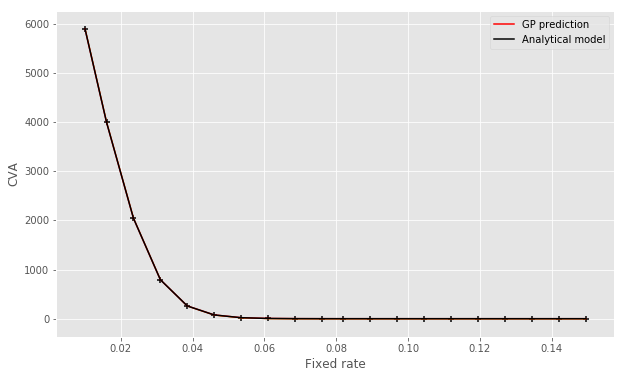

In [99]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(x_test, y_pred, color = 'red', label = 'GP prediction')
plt.plot(x_test, y_test, color = 'black', label = 'Analytical model')
plt.scatter(x_test, y_test, color = 'black', marker = '+', s = 45) 
plt.fill_between(x_test.flatten(), (y_pred-2*sigma), (y_pred+2*sigma), color = 'yellow', alpha=0.5) 
plt.xlabel('Fixed rate')
plt.ylabel('CVA')
plt.legend(loc = 'best', prop={'size':10})
# The var band is too small to be seen relative to the CVA values

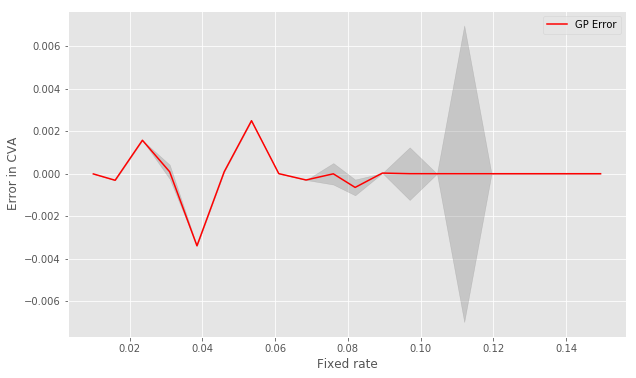

In [53]:
# Error plot
up = y_pred - 2 * sigma   # 95% confident interval 
down = y_pred + 2 * sigma

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test/scaler, y_pred - y_test, color = 'red', label = 'GP Error')
#plt.plot(x_train, y_train, color = 'black', label = 'Analytical Model')
#plt.scatter(x_test, y_test, s = 150, color = 'black', marker = "+")
plt.fill_between(x_test.flatten(), up-y_test, down - y_test, color = 'grey', alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('Fixed rate')
plt.ylabel('Error in CVA')
plt.legend(loc = 'best', prop={'size':10})

Text(0,0.5,'MSE')

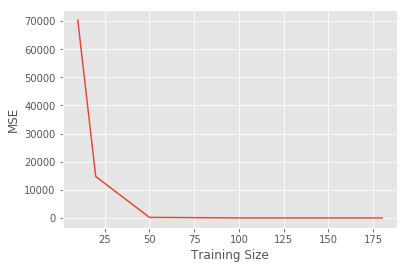

In [399]:
# Convergence plot
size = np.array([10, 20, 50, 100, 160, 180])
plt.plot(size, error)
plt.xlabel('Training Size')
plt.ylabel('MSE')

# Sensitivity study with varying floating rate

In [146]:
df = pd.read_csv('/Users/jinxiwen/Desktop/RA/Cases/CVA Libor data.csv', header=None) 
Libor = np.array(df.iloc[:,1])
test = np.array([ 0.0273956,  0.0273844,  0.0274844])

In [147]:
result = []

In [148]:
for itr in test:
    rate = ql.SimpleQuote(itr)   # Libor + 1% floating rate
    rate_handle = ql.QuoteHandle(rate)
    dc = ql.Actual365Fixed()
    yts = ql.FlatForward(today, rate_handle, dc)
    yts.enableExtrapolation()
    hyts = ql.RelinkableYieldTermStructureHandle(yts)
    t0_curve = ql.YieldTermStructureHandle(yts)
    libor1yr = ql.USDLibor(ql.Period(6, ql.Months), hyts)  
    cal = ql.TARGET()
    
    swaps = [makeSwap(settlementDate,  ql.Period("5Y"), 1e6,  fixedRate,  libor1yr) ]
    calldates = [ql.Date(7,4,2016), ql.Date(6,4,2017), ql.Date(5,4, 2018), ql.Date(5,4,2019)]
    calldates = [libor1yr.valueDate(d) for d in calldates]

    engine = ql.DiscountingSwapEngine(hyts)
    for swap, fixingDates in swaps:
        swap.setPricingEngine(engine)
    
    # Assume the model is already calibrated either historical or market implied
    volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)), ql.QuoteHandle(ql.SimpleQuote(0.0075))]
    meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
    model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
    process = model.stateProcess()
    
    mcDC = yts.dayCounter()
    timeFromReference = timeFromReferenceFactory(mcDC, today)
    
    callTimes = timeFromReference(calldates)
    swap = swaps[0][0]
    npv = swapPathNPV(swap, 0., np.array([0.]))(np.array([0.]))
    
    fixing_dates = fixingdates(swap)
    fixing_times = timeFromReference(fixing_dates )

    date_grid = [today + ql.Period(i, ql.Months) for i in range(0,66)] + calldates + fixing_dates

    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
    time_grid = np.unique(time_grid)
    dt = time_grid[1:] - time_grid[:-1]
    
    seed = 1
    urng = ql.MersenneTwisterUniformRng(seed)
    usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
    generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

    M = 10000
    m = len(time_grid)
    x = np.zeros((M, m))
    y = np.zeros((M, m))
    numeraires = np.zeros((M, m))
                      
    for n in range(0, M):
        numeraires[n, 0] = model.numeraire(0, 0)
    
    for n in range(0,M):
        dWs = generator.nextSequence().value()
        j = 1
        for i in range(1, len(time_grid)):
            t0 = time_grid[i-1]
            t1 = time_grid[i]
            e = process.expectation(t0, x[n,i-1],   dt[i-1])
            std = process.stdDeviation(t0,   x[n,i-1],  dt[i-1])
            x[n,i] = e + dWs[i-1] * std 
            e_0_0 = process.expectation(0,0,t1)
            std_0_0 = process.stdDeviation(0,0,t1)
            y[n,i] = (x[n,i] - e_0_0) / std_0_0
            numeraires[n, i] = model.numeraire(t1, y[n,i])
        
    swap_npvs = np.zeros((M, m))
    cont_value = np.zeros(numeraires[:,i].shape)
    for i in range(m-1, 0, -1):
        t = time_grid[i]
        pricer = swapPathNPV(swap, t, time_grid)
        swap_npvs[:, i] = np.apply_along_axis(pricer, 1, y) / numeraires[:, 0]
        exercise_values = np.zeros(numeraires[:,i].shape)
        if t in callTimes:
            exercise_values = swap_npvs[:, i].copy()
            exercise_values[exercise_values < 0] = 0
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(cont_value, Y)
        ols_result = ols.fit()
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
        if t in callTimes:
            cont_value = np.maximum(cont_value_hat, exercise_values)
    swap_npvs[:, 0] = np.apply_along_axis(swapPathNPV(swap, 0, time_grid), 1, y) / numeraires[:, 0]
    
    swap_npvs *= numeraires[0,0]
    
    swap_npvs[swap_npvs<0] = 0
    EE_swap = np.mean(swap_npvs, axis=0)
    
    pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
    hzrates = [0.02 * i for i in range(11)]
    pd_curve = ql.HazardRateCurve(pd_dates,hzrates,ql.Actual365Fixed())
    pd_curve.enableExtrapolation()
    
    defaultProb_vec = np.vectorize(pd_curve.defaultProbability)
    dPD = defaultProb_vec(time_grid[:-1], time_grid[1:])
    recovery = 0.4
    CVA_swap = (1-recovery) * np.sum(EE_swap[1:] * dPD)
    result.append(CVA_swap)
    print CVA_swap

1277.98310469
1276.21035664
1292.09690829


In [196]:
mse = []

# Fit GP with varying floating rate

In [197]:
df = pd.read_csv('/Users/jinxiwen/Desktop/RA/Cases/CVA_swap_float.csv', header=None)
Libor = np.array(df.iloc[:,1])
CVA = np.array(df.iloc[:,2])

In [240]:
training_number = 250
testing_number = 20

train_idx = np.linspace(0, len(Libor)-1, training_number, dtype = 'int')
test_idx = np.linspace(0, len(Libor)-1, testing_number, dtype = 'int')

x_train = np.array(Libor[train_idx], dtype='float32').reshape(training_number, 1) 
y_train = np.array(CVA[train_idx], dtype='float32')#.reshape(training_number, 1)

x_test = np.array(Libor[test_idx], dtype='float32').reshape(testing_number, 1) 
#x_test_date = np.array(date[test_idx]).reshape(testing_number, 1)
y_test = np.array(CVA[test_idx], dtype='float32')#.reshape(len(result), 1)

In [241]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e+1)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e-4))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer= 20)
gp.fit(x_train, y_train)
gp.kernel_

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.88337603e+01,  -2.80004622e+05]), 'nit': 12, 'funcalls': 86}
  " state: %s" % convergence_dict)
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  -3676.02459136, -279957.27065846]), 'nit': 9, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([    694.40595234, -280003.97436875]), 'nit': 13, 'funcalls': 91}
  " state: %s" %

RBF(length_scale=0.00383) + WhiteKernel(noise_level=0.0001)

In [250]:
y_pred, sigma = gp.predict(x_test, return_std=True)

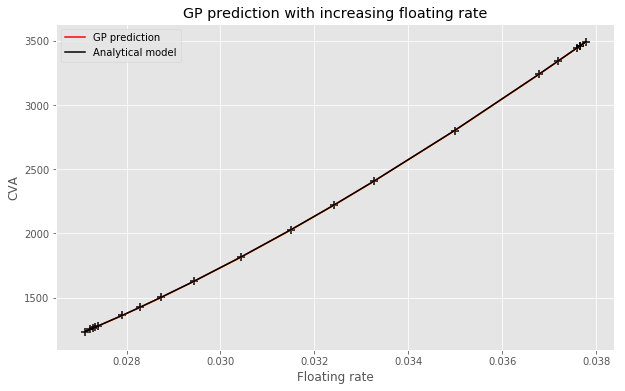

In [243]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(x_test, y_pred, color = 'red', label = 'GP prediction')
plt.plot(x_test, y_test, color = 'black', label = 'Analytical model')
plt.scatter(x_test, y_test, color = 'black', marker = '+', s = 50) 
plt.fill_between(x_test.flatten(), (y_pred-2*sigma), (y_pred+2*sigma), color = 'yellow', alpha=0.5) 
plt.xlabel('Floating rate')
plt.title('GP prediction with increasing floating rate')
plt.ylabel('CVA')
plt.legend(loc = 'best', prop={'size':10})

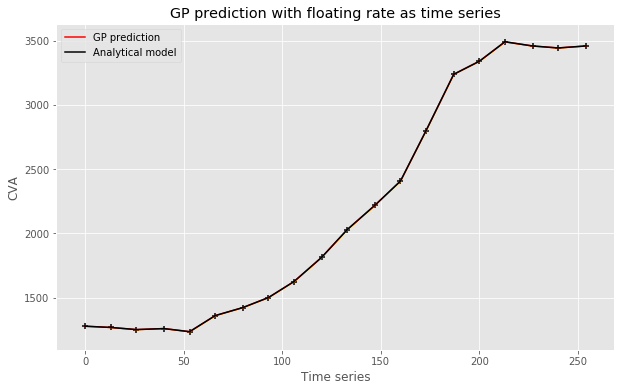

In [244]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
x_axis = np.linspace(0, len(Libor), len(x_test), dtype = 'int')
plt.plot(x_axis, y_pred, color = 'red', label = 'GP prediction')
plt.plot(x_axis, y_test, color = 'black', label = 'Analytical model')
plt.scatter(x_axis, y_test, color = 'black', marker = '+', s = 45) 
plt.fill_between(x_axis, (y_pred-2*sigma), (y_pred+2*sigma), color = 'yellow', alpha=0.5)
plt.title('GP prediction with floating rate as time series')
plt.xlabel('Time series')
plt.ylabel('CVA')
plt.legend(loc = 'best', prop={'size':10})

In [245]:
#mse.append(np.mean((y_pred - y_test)**2))
mse

[11.273441942122393,
 3.8518156100707399,
 1.847632400795155,
 0.66152256871449044,
 0.35351563111734363,
 0.27032646616342826,
 0.19480687014130388]

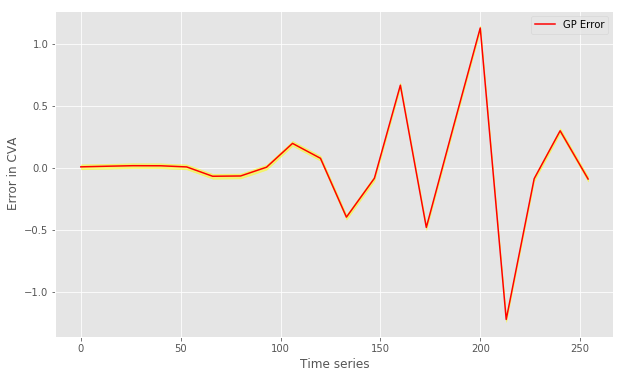

In [246]:
# Error plot
up = y_pred - 2 * sigma   # 95% confident interval 
down = y_pred + 2 * sigma

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_axis, y_pred - y_test, color = 'red', label = 'GP Error')
plt.fill_between(x_axis, up-y_test, down - y_test, color = 'yellow', alpha=0.5)
plt.grid(True)
plt.xlabel('Time series')
plt.ylabel('Error in CVA')
plt.legend(loc = 'best', prop={'size':10})

Text(0,0.5,'MSE')

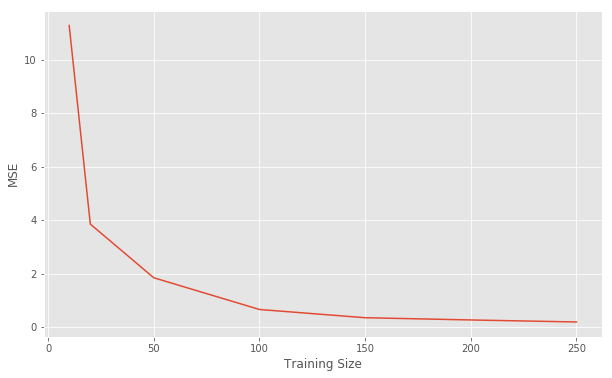

In [248]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
size = np.array([10, 20, 50, 100, 150, 200, 250])
plt.plot(size, mse)
plt.xlabel('Training Size')
plt.ylabel('MSE')